# Calcite solubility in water and CO<sub>2</sub>-saturated rainwater

<p class="acknowledgement">Written by Svetlana Kyas (ETH Zurich) on Feb 8th, 2022</p>

In this tutorial, we investigate the dependence of calcite solubility in water (closed system) and carbon-dioxide
saturated rainwater (open system) on temperature and pressure change.

First, we initialize chemical system with aqueous, gaseous, and calcite phases.

In [1]:
from reaktoro import *
import numpy as np
import matplotlib.pyplot as plt
import math

# Create the database
db = SupcrtDatabase("supcrtbl")

# Create an aqueous phase automatically selecting all species with provided elements
aqueousphase = AqueousPhase(speciate("H O C Ca Mg K Cl Na S N"))
aqueousphase.setActivityModel(chain(
    ActivityModelHKF(),
    ActivityModelDrummond("CO2"),
))

# Create a gaseous phase
gaseousphase = GaseousPhase("CO2(g)")
gaseousphase.setActivityModel(ActivityModelPengRobinson())

# Create a mineral phase
mineral = MineralPhase("Calcite")

# Create the chemical system
system = ChemicalSystem(db, aqueousphase, gaseousphase, mineral)

Next, we set up equilibrium specifications, equilibrium conditions, and equilibrium solver all to be used for the
equilibrium calculations. In order to constrain the charge of the chemical state, we need to make it open to the
Cl<sup>-</sup>. Finally, we create aqueous properties to evaluate pH in the forthcoming calculations.

In [3]:
# Define equilibrium specs
specs = EquilibriumSpecs (system)
specs.temperature()
specs.pressure()
specs.charge()
specs.openTo("Cl-")

# Define equilibrium conditions to be satisfied at chemical equilibrium
conditions = EquilibriumConditions(specs)
conditions.charge(0.0, "mol") # to make sure the mixture is neutral

# Define equilibrium solver
solver = EquilibriumSolver(specs)

# Define aqueous properties
aprops = AqueousProps(system)

Function below defines the chemical states corresponding to the pure water (also referred as a closed system):

In [5]:
def water():

    state = ChemicalState(system)
    state.add("H2O(aq)", 1.0, "kg")

    return state

The function `rainwater()` defines the chemical state corresponding to rainwater saturated with carbon-dioxide:

In [7]:
def rainwater():

    state = ChemicalState(system)
    # Rainwater composition
    state.set("H2O(aq)"    , 1.0, "kg")
    state.set("Na+"    , 2.05, "mg") # Sodium, 2.05 ppm = 2.05 mg/L ~ 2.05 mg/kgw
    state.set("K+"     , 0.35, "mg") # Potassium
    state.set("Ca+2"   , 1.42, "mg") # Calcium
    state.set("Mg+2"   , 0.39, "mg") # Magnesium
    state.set("Cl-"    , 3.47, "mg") # Chloride
    state.set("SO4-2"  , 2.19, "mg")
    state.set("NO3-"   , 0.27, "mg")
    state.set("NH4+"   , 0.41, "mg")
    state.set("CO2(aq)", 0.36, "mol")  # rainwater is saturated with CO2

    return state

Finally, we initialize the array of temperatures from 20 &deg;C till 90 &deg;C and calculate solubilities of calcite
in water and CO<sub>2</sub>-saturated rainwater for pressure P = 1 bar. Function `solubility_of_calcite()` numerically
models chemical equilibrium of 10 mol calcite with a given solute (defined by the input instance `state`):

In [8]:
temperatures = np.arange(20.0, 91.0, 5.0)

def solubility_of_calcite(state, T, P):

    # Initial amount of calcite
    n0Calcite = 10.0

    conditions.temperature(T, "celsius")
    conditions.pressure(P, "bar")

    # Equilibrate the solution given by the chemical state and conditions
    res = solver.solve(state, conditions)

    # If solver didn't succeed return nan
    if not res.optima.succeeded:
        print(f"Equilibrium calculations didn't succeed for {T} C and {P} bar.")
        math.nan

    # Add `n0Calcite` amount of calcite
    state.set("Calcite", n0Calcite, "mol")

    # Equilibrate solution with added calcite
    res = solver.solve(state)

    # If solver didn't succeed return nan
    if not res.optima.succeeded:
        math.nan

    # Update aqueous properties
    aprops.update(state)

    # Calculate pH of the current state
    print(f"T = {T} C: "
          f"ph = {aprops.pH()[0]:.2f}")

    # Fetch the amount of final calcite in the equilibrium state
    nCalcite = state.speciesAmount("Calcite")[0]

    # Return the difference between the initially added and remaining calcite
    return n0Calcite - nCalcite

First, we investigate solubilities of calcite for P = 1.

In [10]:
P = 1.0 # in bar
print(f"Solubility in water (closed system) for P = 1:")
delta_calcite_water_P1 = [solubility_of_calcite(water(), T, P) for T in temperatures]
print(f"Solubility in rainwater for P = 1:")
delta_calcite_rainwater_P1 = [solubility_of_calcite(rainwater(), T, P) for T in temperatures]

Solubility in water (closed system) for P = 1:
T = 20.0 C: ph = 10.01
T = 25.0 C: ph = 9.88
T = 30.0 C: ph = 9.76
T = 35.0 C: ph = 9.64
T = 40.0 C: ph = 9.53
T = 45.0 C: ph = 9.42
T = 50.0 C: ph = 9.31
T = 55.0 C: ph = 9.21
T = 60.0 C: ph = 9.11
T = 65.0 C: ph = 9.01
T = 70.0 C: ph = 8.92
T = 75.0 C: ph = 8.83
T = 80.0 C: ph = 8.74
T = 85.0 C: ph = 8.66
T = 90.0 C: ph = 8.57
Solubility in rainwater for P = 1:
T = 20.0 C: ph = 5.98
T = 25.0 C: ph = 5.97
T = 30.0 C: ph = 5.97
T = 35.0 C: ph = 5.96
T = 40.0 C: ph = 5.96
T = 45.0 C: ph = 5.96
T = 50.0 C: ph = 5.95
T = 55.0 C: ph = 5.95
T = 60.0 C: ph = 5.95
T = 65.0 C: ph = 5.95
T = 70.0 C: ph = 5.95
T = 75.0 C: ph = 5.95
T = 80.0 C: ph = 5.95
T = 85.0 C: ph = 5.95
T = 90.0 C: ph = 5.95


Let us check if the obtained value for 25 &deg;C (second element of the list `delta_calcite_water_P1`) corresponds to the
values of Wikipedia, i.e., the solubility in water equals to 0.013 g/L (25 &deg;C). Below, we use 100.0869 g/mol as
the calcite molar mass:

In [11]:
print(f"Solubility of calcite in water (closed system) equals to {delta_calcite_water_P1[1]:.6f} mol/kgw = ... = "
      f"{delta_calcite_water_P1[1] * 0.1000869 * 1e3:.6f} g/L")

Solubility of calcite in water (closed system) equals to 0.000116 mol/kgw = ... = 0.011592 g/L


Thus, in the closed system (with the pure water), approximately 0.116 mmol of calcite dissolve.
The amount of calcite that dissolves is independent of the initial value (provided that it exceeds the solubility
limit).

Next, we calculate solubilities of calcite in water and CO<sub>2</sub>-saturated rainwater for pressure P = 100 bar.

In [12]:
P = 100.0 # in bar
print(f"Solubility in water (closed system) for P = 100:")
delta_calcite_water_P100 = [solubility_of_calcite(water(), T, P) for T in temperatures]
print(f"Solubility in rainwater (open system) for P = 100:")
delta_calcite_rainwater_P100 = [solubility_of_calcite(rainwater(), T, P) for T in temperatures]

Solubility in water (closed system) for P = 100:
T = 20.0 C: ph = 10.00
T = 25.0 C: ph = 9.87
T = 30.0 C: ph = 9.75
T = 35.0 C: ph = 9.63
T = 40.0 C: ph = 9.52
T = 45.0 C: ph = 9.41
T = 50.0 C: ph = 9.30
T = 55.0 C: ph = 9.20
T = 60.0 C: ph = 9.10
T = 65.0 C: ph = 9.00
T = 70.0 C: ph = 8.91
T = 75.0 C: ph = 8.82
T = 80.0 C: ph = 8.73
T = 85.0 C: ph = 8.65
T = 90.0 C: ph = 8.57
Solubility in rainwater (open system) for P = 100:
T = 20.0 C: ph = 5.38
T = 25.0 C: ph = 5.33
T = 30.0 C: ph = 5.29
T = 35.0 C: ph = 5.25
T = 40.0 C: ph = 5.21
T = 45.0 C: ph = 5.18
T = 50.0 C: ph = 5.15
T = 55.0 C: ph = 5.12
T = 60.0 C: ph = 5.10
T = 65.0 C: ph = 5.08
T = 70.0 C: ph = 5.06
T = 75.0 C: ph = 5.04
T = 80.0 C: ph = 5.02
T = 85.0 C: ph = 5.01
T = 90.0 C: ph = 5.00


Plot solubilities of calcite in water and CO<sub>2</sub>-saturated rainwater for pressure P = 1:

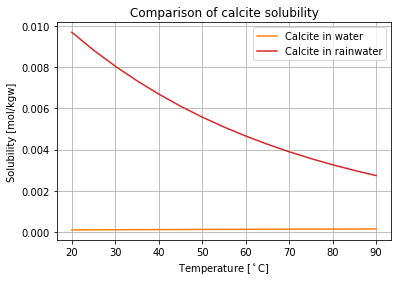

In [13]:
fig, ax = plt.subplots()
ax.plot(temperatures, delta_calcite_water_P1, label=f"Calcite in water", color='C1')
ax.plot(temperatures, delta_calcite_rainwater_P1, label=f"Calcite in rainwater", color='C3')
ax.legend(loc="upper right")
ax.set(xlabel=r'Temperature [$^\circ$C]',
       ylabel='Solubility [mol/kgw]',
       title='Comparison of calcite solubility')
ax.grid()

The plot illustrates that calcium carbonate has very low solubility in pure water, but in rainwater saturated with
carbon dioxide, its solubility increases due to the formation of more soluble calcium bicarbonate. Below, we plot
solubilities on the different scales and for different pressure. We see below that increasing pressure also increases
the solubility of calcium carbonate.

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


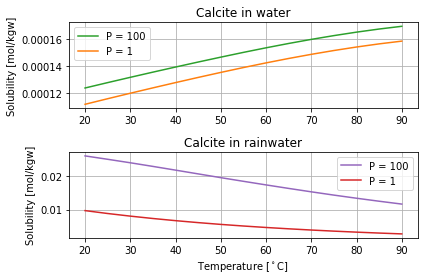

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(temperatures, delta_calcite_water_P100, label="P = 100", color='C2')
ax1.plot(temperatures, delta_calcite_water_P1, label="P = 1", color='C1')
ax1.legend(loc="best")
ax1.set_title('Calcite in water')
ax1.grid()
ax1.set_ylabel('Solubility [mol/kgw]')

ax2.plot(temperatures, delta_calcite_rainwater_P100, label=f"P = 100", color='C4')
ax2.plot(temperatures, delta_calcite_rainwater_P1, label=f"P = 1", color='C3')
ax2.set_title('Calcite in rainwater')
ax2.legend(loc="best")
ax2.grid()
ax2.set_ylabel('Solubility [mol/kgw]')
ax2.set_xlabel(r'Temperature [$^\circ$C]')

fig.tight_layout()